In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
## import training and test data
train=pd.read_csv("train_data.csv")
test=pd.read_csv("test_data.csv")

In [3]:
##examine data
print(train.shape)
print(test.shape)

(43590, 39)
(14531, 39)


In [4]:
##examine available predictors
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

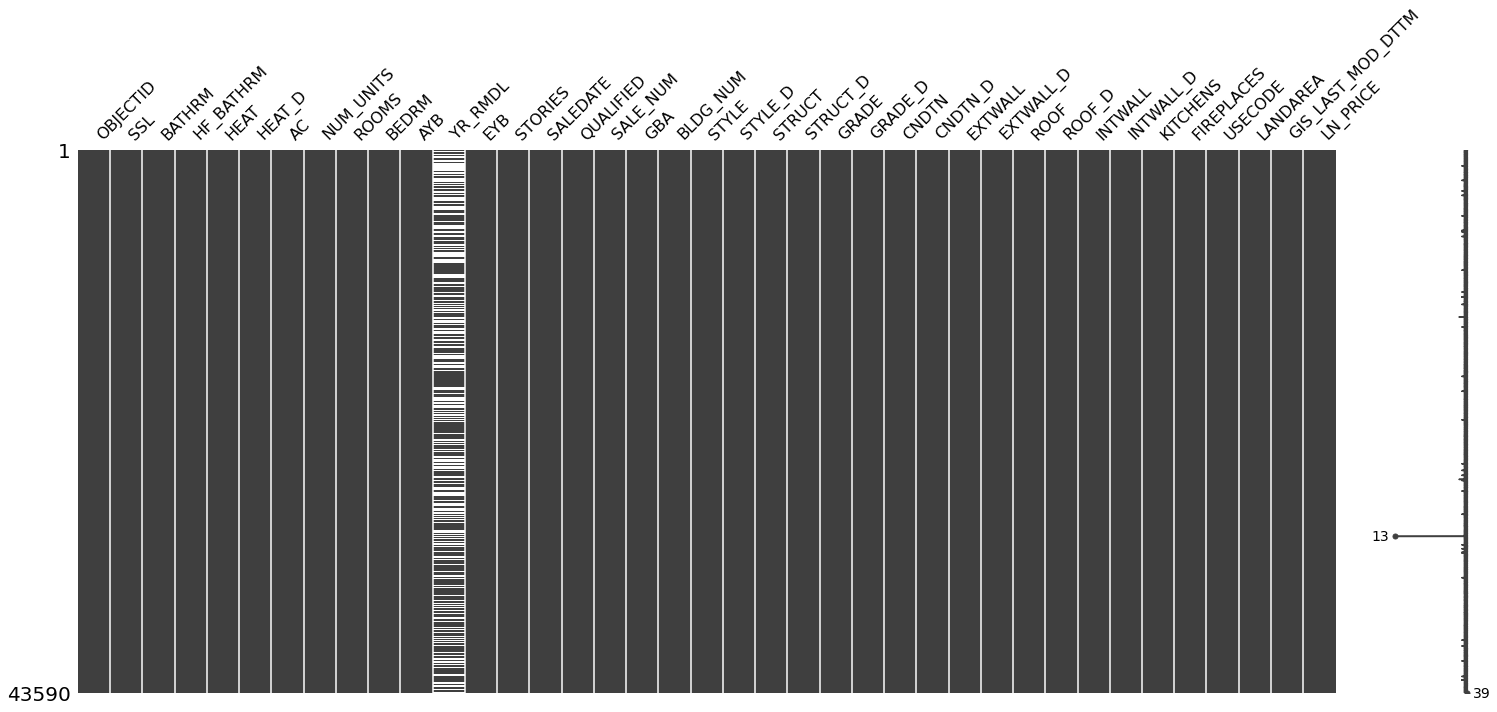

In [5]:
##examine pattern of missingness in training data
miss.matrix(train)

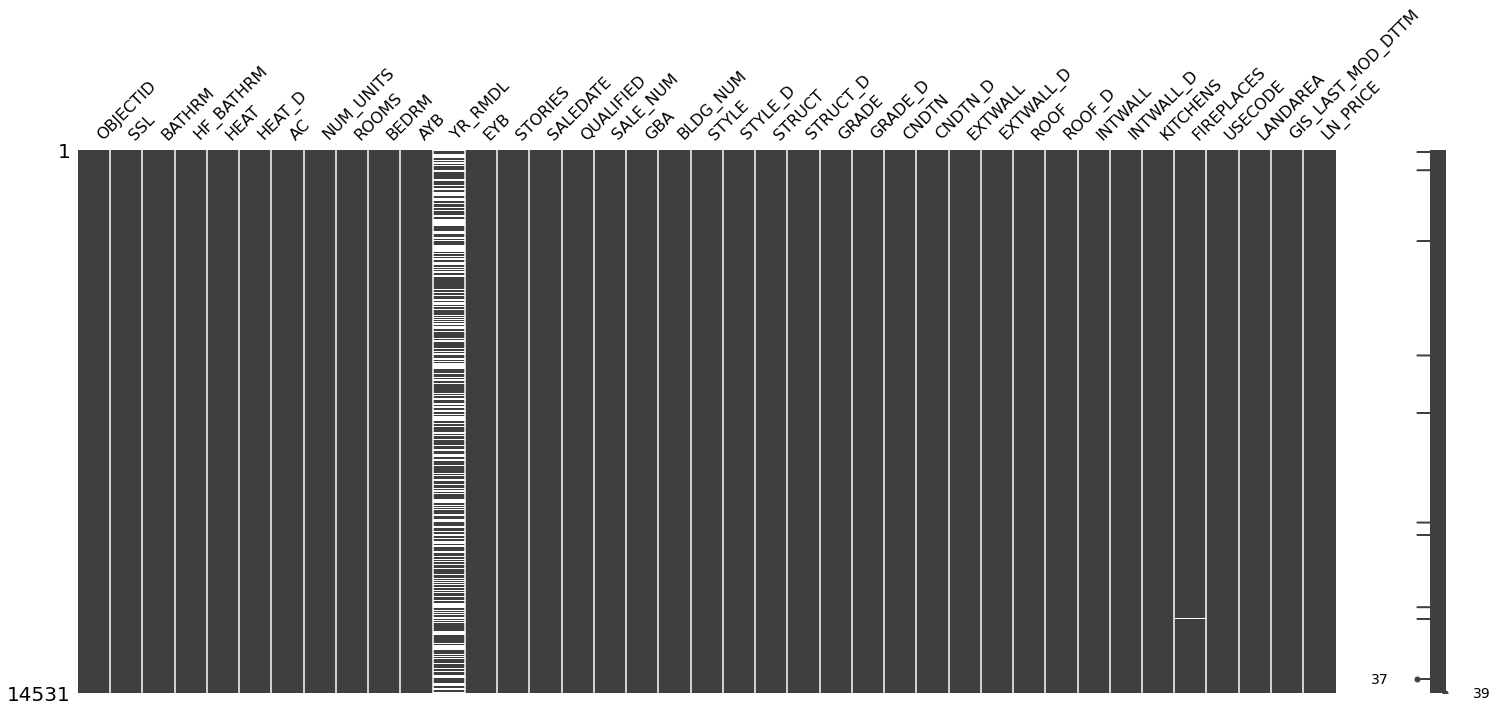

In [6]:
##examine pattern of missingness in test
miss.matrix(test)

In [7]:
##select outcome and predictors
train=train.filter(['LN_PRICE','BATHRM','HEAT','ROOMS','BEDRM','KITCHENS','FIREPLACES','STORIES'])
test=test.filter(['LN_PRICE','BATHRM','HEAT','ROOMS','BEDRM','KITCHENS','FIREPLACES','STORIES'])

In [8]:
# Drop all observations where the outcome is missing 
train = train[~train.LN_PRICE.isna()]
test = test[~test.LN_PRICE.isna()]

# Drop all observation where price is less than 0 (no houses sold)
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

In [9]:
## replace all nan values and change infinite values to finite (FOR TRAINING)
col_names = list(train) ##isolate column headers
train=np.nan_to_num(train)## adjust nan and infinite values
train = pd.DataFrame(train,columns=col_names)##change to dataframe

In [10]:
## replace all nan values and change infinite values to finite (FOR TEST)
test=np.nan_to_num(test)## adjust nan and infinite values
test= pd.DataFrame(test,columns=col_names)##change to dataframe

In [11]:
##separate outcome variables in train and test data 
train_y=train['LN_PRICE']
test_y=test['LN_PRICE']

In [12]:
##select predictors(7 in total) from train and test data set 
train_X=train[['BATHRM','HEAT','ROOMS','BEDRM','KITCHENS','FIREPLACES','STORIES']]
test_X=test[['BATHRM','HEAT','ROOMS','BEDRM','KITCHENS','FIREPLACES','STORIES']]

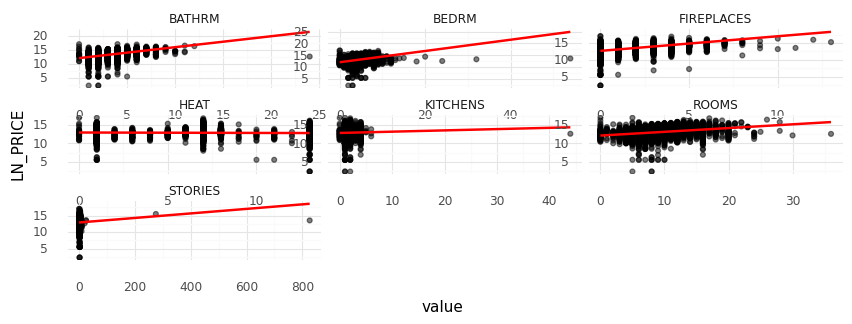

<ggplot: (8766646169426)>

In [13]:
## visualize predictors alongside outcome
D = train_X.copy()
D['LN_PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["LN_PRICE"]),
           aes(x="value",y="LN_PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [14]:
##pre-process data; adjust scales
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [15]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,HEAT,ROOMS,BEDRM,KITCHENS,FIREPLACES,STORIES
0,0.125000,0.076923,0.250000,0.074074,0.022727,0.000000,0.002421
1,0.083333,0.538462,0.194444,0.055556,0.022727,0.076923,0.002421
2,0.083333,1.000000,0.250000,0.074074,0.022727,0.076923,0.003027
3,0.041667,0.538462,0.166667,0.055556,0.022727,0.000000,0.002421
4,0.083333,1.000000,0.305556,0.074074,0.022727,0.000000,0.002421
...,...,...,...,...,...,...,...
43583,0.041667,0.076923,0.138889,0.037037,0.022727,0.076923,0.002421
43584,0.083333,1.000000,0.194444,0.055556,0.022727,0.076923,0.002421
43585,0.083333,1.000000,0.250000,0.074074,0.022727,0.153846,0.003632
43586,0.125000,0.076923,0.166667,0.055556,0.045455,0.076923,0.002421


In [16]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

In [17]:
## use mean squared error as performance metric
use_metrics = ["neg_mean_squared_error"]

__Test Models__

Linear Model

In [18]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

KNN

In [19]:
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

Decision Tree

In [20]:
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

Bagging

In [21]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

Random Forest

In [22]:
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

__Compare models__

In [23]:
##compile metrics as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

##convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.488337
1,lm,0.484046
2,lm,0.486378
3,lm,0.474334
4,lm,2.266906
5,knn,0.545649
6,knn,0.540214
7,knn,0.521531
8,knn,0.521911
9,knn,0.541318


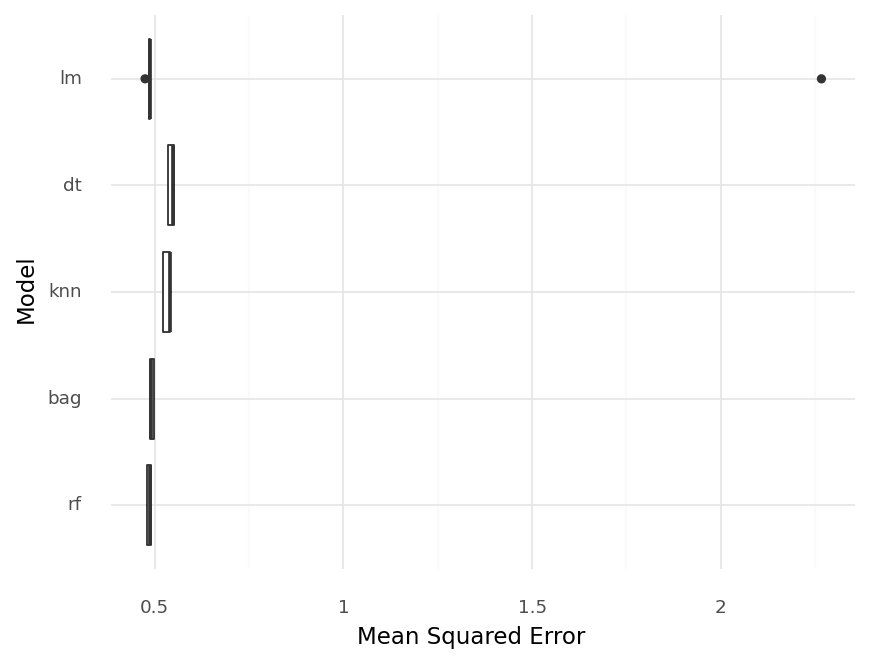

<ggplot: (8766645743261)>

In [24]:
## get order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Random forest and Linear Model appear to be doing the best.

__Model Tuning__

KNN: try a range of values for k

In [25]:
## try out different values for K and assess mean squared error
set_k = dict()
for k in [5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X,train_y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k

{5: -0.5341245682010748,
 10: -0.4901696479544196,
 50: -0.4632386161544984,
 100: -0.4620188325654865,
 250: -0.4658417709443631}

In [26]:
## explore a set of tuning parameters
knn_tune_params = {'n_neighbors':[50, 55,60, 75, 100]}

In [27]:
## run model under different configurations
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [28]:
##fit model 
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [50, 55, 60, 75, 100]},
             scoring='neg_mean_squared_error')

In [29]:
## report best fitting parameter and score
print(tune_knn.best_params_)
print(tune_knn.best_score_)

{'n_neighbors': 75}
-0.46168958542703165


Decision Tree: explore the max_depth parameter

In [30]:
## apply a range of values from 1-15 to depth of tree
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(15)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [31]:
## fit model
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14]},
             scoring='neg_mean_squared_error')

In [32]:
## report best fitting parameter and score
print(tune_dt.best_params_)
print(tune_dt.best_score_)

{'max_depth': 6}
-0.46014041800703154


Random Forest: explore max_depth, n_estimators, and max_features parameters

In [33]:
## set parameters
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
            'max_features':[1,2,3]}
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [34]:
## fit model
tune_rf.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2, 3],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [35]:
## report best fitting parameter and score
print(tune_rf.best_params_)
print(tune_rf.best_score_)

{'max_depth': 3, 'max_features': 3, 'n_estimators': 100}
-0.4791552526907907


__Modeling Pipeline__

In [36]:
##specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','HEAT','ROOMS','BEDRM','KITCHENS','FIREPLACES','STORIES'])])


##create model pipe 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


## specify the models and repsective tuning parameters. 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[50, 55,60, 75, 100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[4, 5, 6, 7, 8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[3,4,5],
     'model__n_estimators':[100,500,1000]},
]


## combine in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

## fit model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'HEAT',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'KITCHENS',
                                                                          'FIREPLACES',
                                                                          'STORIES'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model

In [37]:
## best score
search.best_score_ 

-0.4577804781940569

In [38]:
##best model and parameter
search.best_params_

{'model': RandomForestRegressor(max_depth=5, n_estimators=1000),
 'model__max_depth': 5,
 'model__n_estimators': 1000}

__Test Performance__

In [39]:
## use the best model out of scan
pred_y = search.predict(test_X)

In [40]:
##mean squared error from best model
m.mean_squared_error(test_y,pred_y)

1.8071086476923068